In [ ]:

pip install bunch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Utility Codes

### Parameter Setting

In [ ]:
import os
import time
import json
from bunch import Bunch

import pandas as pd

df= pd.read_csv('vocab.csv')
vocab = df['Smiles'].tolist()

def get_config_from_json(json_file):
    with open(json_file, 'r') as config_file:
        config_dict = json.load(config_file)
    config = Bunch(config_dict)
    return config


def process_config(json_file):
    config = get_config_from_json(json_file)
    config.config_file = json_file
    config.exp_dir = os.path.join(
        'experiments', time.strftime('%Y-%m-%d/', time.localtime()),
        config.exp_name)
    config.tensorboard_log_dir = os.path.join(
        'experiments', time.strftime('%Y-%m-%d/', time.localtime()),
        config.exp_name, 'logs/')
    config.checkpoint_dir = os.path.join(
        'experiments', time.strftime('%Y-%m-%d/', time.localtime()),
        config.exp_name, 'checkpoints/')
    return config

### Creating Directory

In [ ]:
import os
import sys


def create_dirs(dirs):
    try:
        for dir_ in dirs:
            if not os.path.exists(dir_):
                os.makedirs(dir_)
    except Exception as err:
        print(f'Creating directories error: {err}')
        sys.exit()

## Building Function Vocabulary

In [ ]:
import pandas as pd

df = pd.read_csv('functions.csv')
df


,Unnamed: 0,Len,Functional grp name,SMARTS,Smiles,Validity
0,0,7,Acid anhydrides,[CX3](=[OX1])[OX2][CX3](=[OX1]),O=COC=O,Valid
1,1,8,Diacyl peroxides,[CX3](=[OX1])[OX2][OX2][CX3](=[OX1]),O=COOC=O,Valid
2,2,15,Phenyl esters,[cR1]1([OX2][CX3](=[OX1])[#6])[cR1][cR1][cR1][...,CC(=O)Oc1ccccc1,Valid
3,3,5,Isocyanates,[NX2]=[CX2]=[OX1],N=C=O,Valid
4,4,8,β-Lactams,[NX3]1[CX4][CX4][CX3]1(=[OX1]),O=C1CCN1,Valid
...,...,...,...,...,...,...
1240,1240,12,SA46,[#6]-1-2-[#6]=[#6]-[#6](-[#6]-1)-[#6]-[#6]-2,C1=CC2CCC1C2,Valid
1241,1241,11,SA47,[#6]-1-2-[#6]-[#6]-[#6](-[#6]-1)-[#6]-[#6]-2,C1CC2CCC1C2,Valid
1242,1242,19,SA48,c1(c(cccc1)-[#8]-c2ccccc2)-[Br],Brc1ccccc1Oc1ccccc1,Valid
1243,1243,15,SA49,c1-2c(cccc1)-[#6]-[#6]-[#6]-2,c1ccc2c(c1)CCC2,Valid


In [ ]:
df_filtered = df[df.Len < 13]
print(df_filtered.shape)
vocab = df_filtered['Smiles'].tolist()

(673, 6)


## SMILES TOKENIZER

In [ ]:
import numpy as np


class SmilesTokenizer(object):
    def __init__(self):
        atoms = [
            'Al', 'As', 'B', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'K', 'Li', 'N',
            'Na', 'O', 'P', 'S', 'Se', 'Si', 'Te'
        ]
        special = [
            '(', ')', '[', ']', '=', '#', '%', '0', '1', '2', '3', '4', '5',
            '6', '7', '8', '9', '+', '-', 'se', 'te', 'c', 'n', 'o', 's'
        ]

        function = vocab



        padding = ['G', 'A', 'E']

        self.table = sorted(function, key=len, reverse=True) + sorted(vocab, key=len, reverse=True)  + padding + special
        table_len = len(self.table)

        self.table_12_chars = list(filter(lambda x: len(x) == 12, self.table))
        self.table_11_chars = list(filter(lambda x: len(x) == 11, self.table))
        self.table_10_chars = list(filter(lambda x: len(x) == 10, self.table))
        self.table_9_chars = list(filter(lambda x: len(x) == 9, self.table))
        self.table_8_chars = list(filter(lambda x: len(x) == 8, self.table))
        self.table_7_chars = list(filter(lambda x: len(x) == 7, self.table))
        self.table_6_chars = list(filter(lambda x: len(x) == 6, self.table))
        self.table_5_chars = list(filter(lambda x: len(x) == 5, self.table))
        self.table_4_chars = list(filter(lambda x: len(x) == 4, self.table))
        self.table_3_chars = list(filter(lambda x: len(x) == 3, self.table))
        self.table_2_chars = list(filter(lambda x: len(x) == 2, self.table))
        self.table_1_chars = list(filter(lambda x: len(x) == 1, self.table))



        self.one_hot_dict = {}
        for i, symbol in enumerate(self.table):
            vec = np.zeros(table_len, dtype=np.float32)
            vec[i] = 1
            self.one_hot_dict[symbol] = vec

    def tokenize(self, smiles):

        N = len(smiles)
        token = []
        i = 0
        while (i < N):
            c1 = smiles[i]
            c2 = smiles[i:i + 2]
            c3 = smiles[i:i + 3]
            c4 = smiles[i:i + 4]
            c5 = smiles[i:i + 5]
            c6 = smiles[i:i + 6]
            c7 = smiles[i:i + 7]
            c8 = smiles[i:i + 8]
            c9 = smiles[i:i + 9]
            c10 = smiles[i:i + 10]
            c11 = smiles[i:i + 11]

            c12= smiles[i:i + 12]

            if c12 in self.table_12_chars:
                token.append(c12)
                i += 12
                continue

            if c11 in self.table_11_chars:
                token.append(c11)
                i += 11
                continue

            if c10 in self.table_10_chars:
                token.append(c10)
                i += 10
                continue

            if c9 in self.table_9_chars:
                token.append(c9)
                i += 9
                continue  
            
            if c8 in self.table_8_chars:
                token.append(c8)
                i += 8
                continue

            if c7 in self.table_7_chars:
                token.append(c7)
                i += 7
                continue

            if c6 in self.table_6_chars:
                token.append(c6)
                i += 6
                continue

            if c5 in self.table_5_chars:
                token.append(c5)
                i += 5
                continue

            if c4 in self.table_4_chars:
                token.append(c4)
                i += 4
                continue

            if c3 in self.table_3_chars:
                token.append(c3)
                i += 3
                continue          


            if c2 in self.table_2_chars:
                token.append(c2)
                i += 2
                continue

            if c1 in self.table_1_chars:
                token.append(c1)
                i += 1
                continue



            i += 1
        
        #print(token)
        return token



    def one_hot_encode(self, tokenized_smiles):
        result = np.array(
            [self.one_hot_dict[symbol] for symbol in tokenized_smiles],
            dtype=np.float32)
        result = result.reshape(1, result.shape[0], result.shape[1])
        ##print(result)
        return result


## Data Loader

In [ ]:

import json
import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.utils import Sequence
#from lstm_chem.utils.smiles_tokenizer2 import SmilesTokenizer


class DataLoader(Sequence):
    def __init__(self, config, data_type='train'):
        self.config = config
        self.data_type = data_type
        assert self.data_type in ['train', 'valid', 'finetune']

        self.max_len = 0

        if self.data_type == 'train':
            self.smiles = self._load(self.config.data_filename)
        elif self.data_type == 'finetune':
            self.smiles = self._load(self.config.finetune_data_filename)
        else:
            pass

        self.st = SmilesTokenizer()
        self.one_hot_dict = self.st.one_hot_dict

        self.tokenized_smiles = self._tokenize(self.smiles)

        if self.data_type in ['train', 'valid']:
            self.idx = np.arange(len(self.tokenized_smiles))
            self.valid_size = int(
                np.ceil(
                    len(self.tokenized_smiles) * self.config.validation_split))
            np.random.seed(self.config.seed)
            np.random.shuffle(self.idx)

    def _set_data(self):
        if self.data_type == 'train':
            ret = [
                self.tokenized_smiles[self.idx[i]]
                for i in self.idx[self.valid_size:]
            ]
        elif self.data_type == 'valid':
            ret = [
                self.tokenized_smiles[self.idx[i]]
                for i in self.idx[:self.valid_size]
            ]
        else:
            ret = self.tokenized_smiles
        return ret

    def _load(self, data_filename):
        length = self.config.data_length
        print('loading SMILES...')
        with open(data_filename) as f:
            smiles = [s.rstrip() for s in f]
        if length != 0:
            smiles = smiles[:length]
        print('done.')
        return smiles

    def _tokenize(self, smiles):
        assert isinstance(smiles, list)
        print('tokenizing SMILES...')
        tokenized_smiles = [self.st.tokenize(smi) for smi in tqdm(smiles)]

        if self.data_type == 'train':
            for tokenized_smi in tokenized_smiles:
                length = len(tokenized_smi)
                if self.max_len < length:
                    self.max_len = length
            self.config.train_smi_max_len = self.max_len
        print('done.')
        return tokenized_smiles

    def __len__(self):
        target_tokenized_smiles = self._set_data()
        if self.data_type in ['train', 'valid']:
            ret = int(
                np.ceil(
                    len(target_tokenized_smiles) /
                    float(self.config.batch_size)))
        else:
            ret = int(
                np.ceil(
                    len(target_tokenized_smiles) /
                    float(self.config.finetune_batch_size)))
        return ret

    def __getitem__(self, idx):
        target_tokenized_smiles = self._set_data()
        if self.data_type in ['train', 'valid']:
            data = target_tokenized_smiles[idx *
                                           self.config.batch_size:(idx + 1) *
                                           self.config.batch_size]
        else:
            data = target_tokenized_smiles[idx *
                                           self.config.finetune_batch_size:
                                           (idx + 1) *
                                           self.config.finetune_batch_size]
        data = self._padding(data)

        self.X, self.y = [], []
        for tp_smi in data:
            X = [self.one_hot_dict[symbol] for symbol in tp_smi[:-1]]
            self.X.append(X)
            y = [self.one_hot_dict[symbol] for symbol in tp_smi[1:]]
            self.y.append(y)

        self.X = np.array(self.X, dtype=np.float32)
        self.y = np.array(self.y, dtype=np.float32)
        
#        return self.X, self.y, [None]
        return self.X, self.y

    def _pad(self, tokenized_smi):
        return ['G'] + tokenized_smi + ['E'] + [
            'A' for _ in range(self.max_len - len(tokenized_smi))
        ]

    def _padding(self, data):
        padded_smiles = [self._pad(t_smi) for t_smi in data]
        return padded_smiles

## LSTM Model

In [ ]:
import os
import time
from tensorflow.keras import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.initializers import RandomNormal



class LSTMChem(object):
    def __init__(self, config, session='train'):
        assert session in ['train', 'generate', 'finetune'], \
                'one of {train, generate, finetune}'

        self.config = config
        self.session = session
        self.model = None

        if self.session == 'train':
            self.build_model()
        else:
            self.model = self.load(self.config.model_arch_filename,
                                   self.config.model_weight_filename)

    def build_model(self):
        st = SmilesTokenizer()
        n_table = len(st.table)
        weight_init = RandomNormal(mean=0.0,
                                   stddev=0.05,
                                   seed=self.config.seed)

        self.model = Sequential()
        self.model.add(
            LSTM(units=self.config.units,
                 input_shape=(None, n_table),
                 return_sequences=True,
                 kernel_initializer=weight_init,
                 dropout=0.1))
        self.model.add(
            LSTM(units=self.config.units,
                 input_shape=(None, n_table),
                 return_sequences=True,
                 kernel_initializer=weight_init,
                 dropout=0.2))
        self.model.add(
            Dense(units=n_table,
                  activation='softmax',
                  kernel_initializer=weight_init))

        arch = self.model.to_json(indent=2)
        self.config.model_arch_filename = os.path.join(self.config.exp_dir,
                                                       'model_arch.json')
        with open(self.config.model_arch_filename, 'w') as f:
            f.write(arch)

        self.model.compile(optimizer=self.config.optimizer,
                           loss='categorical_crossentropy')

    def save(self, checkpoint_path):
        assert self.model, 'You have to build the model first.'

        print('Saving model ...')
        self.model.save_weights(checkpoint_path)
        print('model saved.')

    def load(self, model_arch_file, checkpoint_file):
        print(f'Loading model architecture from {model_arch_file} ...')
        with open(model_arch_file) as f:
            model = model_from_json(f.read())
        print(f'Loading model checkpoint from {checkpoint_file} ...')
        model.load_weights(checkpoint_file)
        print('Loaded the Model.')
        return model

## Generator

In [ ]:
from tqdm import tqdm
import numpy as np
#from lstm_chem.utils.smiles_tokenizer2 import SmilesTokenizer


class LSTMChemGenerator(object):
    def __init__(self, modeler):
        self.session = modeler.session
        self.model = modeler.model
        self.config = modeler.config
        self.st = SmilesTokenizer()

    def _generate(self, sequence):
        while (sequence[-1] != 'E') and (len(self.st.tokenize(sequence)) <=
                                         self.config.smiles_max_length):
            x = self.st.one_hot_encode(self.st.tokenize(sequence))
            preds = self.model.predict_on_batch(x)[0][-1]
            next_idx = self.sample_with_temp(preds)
            sequence += self.st.table[next_idx]

        sequence = sequence[1:].rstrip('E')

        return sequence


    def sample_with_temp(self, preds):
        streched = np.log(preds) / self.config.sampling_temp
        streched_probs = np.exp(streched) / np.sum(np.exp(streched))
        return np.random.choice(range(len(streched)), p=streched_probs)

    def sample(self, num=1, start='G'):
        sampled = []
        if self.session == 'generate':
            for _ in tqdm(range(num)):
                sampled.append(self._generate(start))
            return sampled
        else:
            from rdkit import Chem, RDLogger
            RDLogger.DisableLog('rdApp.*')
            while len(sampled) < num:
                sequence = self._generate(start)
                mol = Chem.MolFromSmiles(sequence)
                if mol is not None:
                    canon_smiles = Chem.MolToSmiles(mol)
                    sampled.append(canon_smiles)
            return sampled

## Fine Tuner

In [ ]:



class LSTMChemFinetuner(LSTMChemGenerator):
    def __init__(self, modeler, finetune_data_loader):
        self.session = modeler.session
        self.model = modeler.model
        self.config = modeler.config
        self.finetune_data_loader = finetune_data_loader
        self.st = SmilesTokenizer()

    def finetune(self):
        self.model.compile(optimizer=self.config.optimizer,
                           loss='categorical_crossentropy')

#        history = self.model.fit_generator(
        history = self.model.fit(
            self.finetune_data_loader,
            steps_per_epoch=self.finetune_data_loader.__len__(),
            epochs=self.config.finetune_epochs,
            verbose=self.config.verbose_training,
            use_multiprocessing=True,
            shuffle=True)
        return history


## Trainer

In [ ]:
from glob import glob
import os
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard


class LSTMChemTrainer(object):
    def __init__(self, modeler, train_data_loader, valid_data_loader):
        self.model = modeler.model
        self.config = modeler.config
        self.train_data_loader = train_data_loader
        self.valid_data_loader = valid_data_loader
        self.callbacks = []
        self.init_callbacks()

    def init_callbacks(self):
        self.callbacks.append(
            ModelCheckpoint(
                filepath=os.path.join(
                    self.config.checkpoint_dir,
                    '%s-{epoch:02d}-{val_loss:.2f}.hdf5' %
                    self.config.exp_name),
                monitor=self.config.checkpoint_monitor,
                mode=self.config.checkpoint_mode,
                save_best_only=self.config.checkpoint_save_best_only,
                save_weights_only=self.config.checkpoint_save_weights_only,
                verbose=self.config.checkpoint_verbose,
            ))
        self.callbacks.append(
            TensorBoard(
                log_dir=self.config.tensorboard_log_dir,
                write_graph=self.config.tensorboard_write_graph,
            ))

    def train(self):
#        history = self.model.fit_generator(
        history = self.model.fit(
            self.train_data_loader,
            steps_per_epoch=self.train_data_loader.__len__(),
            epochs=self.config.num_epochs,
            verbose=self.config.verbose_training,
            validation_data=self.valid_data_loader,
            validation_steps=self.valid_data_loader.__len__(),
            use_multiprocessing=True,
            shuffle=True,
            callbacks=self.callbacks)

        last_weight_file = glob(
            os.path.join(
                f'{self.config.checkpoint_dir}',
                f'{self.config.exp_name}-{self.config.num_epochs:02}*.hdf5')
        )[0]

        assert os.path.exists(last_weight_file)
        self.config.model_weight_filename = last_weight_file

        with open(os.path.join(self.config.exp_dir, 'config.json'), 'w') as f:
            f.write(self.config.toJSON(indent=2))

## Training

In [ ]:
'''
from copy import copy
#from lstm_chem.utils.config import process_config
#from lstm_chem.utils.dirs import create_dirs
#from lstm_chem.data_loader import DataLoader
#from lstm_chem.model import LSTMChem
#from lstm_chem.trainer import LSTMChemTrainer

CONFIG_FILE = '/content/base_config.json'


def main():
    config = process_config(CONFIG_FILE)

    # create the experiments dirs
    create_dirs(
        [config.exp_dir, config.tensorboard_log_dir, config.checkpoint_dir])

    print('Create the data generator.')
    train_dl = DataLoader(config, data_type='train')
    valid_dl = copy(train_dl)
    valid_dl.data_type = 'valid'

    print('Create the model.')
    modeler = LSTMChem(config, session='train')

    print('Create the trainer')
    trainer = LSTMChemTrainer(modeler, train_dl, valid_dl)

    print('Start training the model.')
    trainer.train()


if __name__ == '__main__':
    main()

'''

"\nfrom copy import copy\n#from lstm_chem.utils.config import process_config\n#from lstm_chem.utils.dirs import create_dirs\n#from lstm_chem.data_loader import DataLoader\n#from lstm_chem.model import LSTMChem\n#from lstm_chem.trainer import LSTMChemTrainer\n\nCONFIG_FILE = '/content/base_config.json'\n\n\ndef main():\n    config = process_config(CONFIG_FILE)\n\n    # create the experiments dirs\n    create_dirs(\n        [config.exp_dir, config.tensorboard_log_dir, config.checkpoint_dir])\n\n    print('Create the data generator.')\n    train_dl = DataLoader(config, data_type='train')\n    valid_dl = copy(train_dl)\n    valid_dl.data_type = 'valid'\n\n    print('Create the model.')\n    modeler = LSTMChem(config, session='train')\n\n    print('Create the trainer')\n    trainer = LSTMChemTrainer(modeler, train_dl, valid_dl)\n\n    print('Start training the model.')\n    trainer.train()\n\n\nif __name__ == '__main__':\n    main()\n\n"

In [ ]:
 #!zip -r exp.zip experiments/

In [ ]:
#from google.colab import files
#files.download("/content/exp.zip")

## Fine Tuning

In [ ]:
pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

#from lstm_chem.utils.config import process_config
#from lstm_chem.model import LSTMChem
#from lstm_chem.finetuner import LSTMChemFinetuner
#from lstm_chem.data_loader import DataLoader

In [ ]:
config = process_config('/content/config.json')

modeler = LSTMChem(config, session='finetune')
finetune_dl = DataLoader(config, data_type='finetune')

finetuner = LSTMChemFinetuner(modeler, finetune_dl)
finetuner.finetune()

Loading model architecture from /content/drive/MyDrive/DDP FSR/experiments/2023-02-27/LSTM_Chem/model_arch.json ...
Loading model checkpoint from /content/drive/MyDrive/DDP FSR/experiments/2023-02-27/LSTM_Chem/checkpoints/LSTM_Chem-04-0.44.hdf5 ...
Loaded the Model.
loading SMILES...
done.
tokenizing SMILES...


100%|██████████| 1567/1567 [00:03<00:00, 420.78it/s]


done.
Epoch 1/15
1567/1567 [==============================] - 30s 14ms/step - loss: 1.7070
Epoch 2/15
1567/1567 [==============================] - 18s 11ms/step - loss: 1.4273
Epoch 3/15
1567/1567 [==============================] - 17s 11ms/step - loss: 1.3239
Epoch 4/15
1567/1567 [==============================] - 18s 12ms/step - loss: 1.2488
Epoch 5/15
1567/1567 [==============================] - 19s 12ms/step - loss: 1.2020
Epoch 6/15
1567/1567 [==============================] - 18s 12ms/step - loss: 1.1559
Epoch 7/15
1567/1567 [==============================] - 18s 11ms/step - loss: 1.0998
Epoch 8/15
1567/1567 [==============================] - 19s 12ms/step - loss: 1.0606
Epoch 9/15
1567/1567 [==============================] - 18s 11ms/step - loss: 1.0335
Epoch 10/15
1567/1567 [==============================] - 18s 11ms/step - loss: 0.9963
Epoch 11/15
1567/1567 [==============================] - 19s 12ms/step - loss: 0.9668
Epoch 12/15
1567/1567 [==============================] - 

In [ ]:
finetuned_smiles = finetuner.sample(num=100)

In [ ]:
finetuned_smiles


['Cc1ccc2c(c1)C(C)C(CCCN(C)C)C1=C(C1)N2',
 'CC(C)(C)C',
 'CCCCCC',
 'CN(C)CCON=C1c2ccccc2CCc2ccccc21',
 'CC(C)(O)C(O)c1ccc(O)cc1',
 'CCC',
 'Cc1cc(O)ccc1C=C1[C]2CN(C)C2CC1=O',
 'CCNc1cccc(C)c1C=Cc1ccccc1',
 'CC(=O)c1cncn1CC1CCCCC1',
 'CCCC(C)C1(C)C(=O)NC(=O)NC1=O',
 'CCN(CC)C(=O)C1CCn2cnc1c2C(C)C',
 'CC(C)C',
 'C=C',
 'NCCc1ccccc1',
 'CNCCc1ccccn1',
 'CN(C)CCON1c2ccccc2C=Cc2ccccc21',
 'CN1C(=O)CC(c2ccccc2)C1=O',
 'NC1=NC(=O)C1N(C(=O)C1=CC1)c1ccccc1',
 'Cc1ccc2c(c1)C(c1ccccc1)=NCC(=O)N2C',
 'NC(=O)NO',
 'NC(=O)Nc1cccc(O)c1O',
 'CN1C(=O)CCC1Cc1ccccc1',
 'Cc1ccc2[nH]c(=O)nc(-c3ccccc3)c2c1',
 'CCN1c2ccccc2Sc2ccccc21',
 'CC(=C1CCC(=O)NC1=O)c1ccccc1',
 'COc1ccc2c(c1)N(CC(C)CN(C)C)c1ccccc1S2',
 'CCOC(=O)Oc1ccccc1C(C)C',
 'C=C',
 'CCCC(=O)C(=O)n1c2ccccc3sc3ccc(C)cc21',
 'NC1OCC(c2ccccc2)=NC1=O',
 'CCC',
 'CC1CC(CNC(=O)c2cc(S(C)(=O)=O)ccc2N)N1C',
 'C=C',
 'CCc1ccccc1',
 'CC1CCCCN1',
 'O=C(O)Oc1cc2ccccc2s1',
 'CCC(O)CC1(CC)C(=O)NC(=O)NC1=O',
 'Cc1ccc2c(c1)N(C)CCC(C)C2=O',
 'CC(C)(C)OC(=O)C(C)(C)

In [ ]:
with open('/content/bbbp.txt') as f:
    ksmiles = [l.rstrip() for l in f]
kmols = [Chem.MolFromSmiles(smi) for smi in ksmiles]

Kfps = []
for mol in kmols:
  try:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Kfps.append(fp)
  except:
    pass
Klen = len(Kfps)

In [ ]:
with open('/content/bbbp.txt') as f:
    fsmiles = [l.rstrip() for l in f]
fmols = [Chem.MolFromSmiles(smi) for smi in fsmiles]

Ffps, Fbvs = [], []
for mol in fmols:
  try:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Fbvs.append(bv)
    
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ffps.append(fp)
  except:
    pass
Flen = len(Ffps)

In [ ]:
Sfps, Sbvs, smols = [], [], []
for smi in finetuned_smiles:
    mol = Chem.MolFromSmiles(smi)
    smols.append(mol)
    
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Sbvs.append(bv)
    
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Sfps.append(fp)



In [ ]:
x = Kfps + Ffps + Sfps
pca = PCA(n_components=2, random_state=71)
X = pca.fit_transform(x)

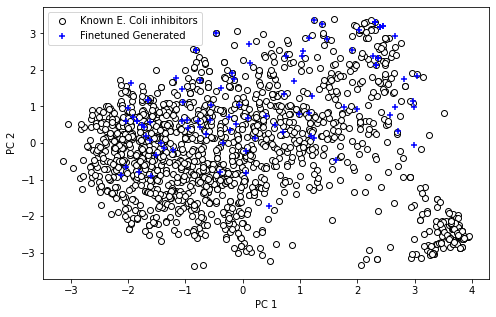

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:Klen, 0], X[:Klen, 1],
            c='w', edgecolors='k', label='Known E. Coli inhibitors')
#plt.scatter(X[Klen:Klen + Flen, 0], X[Klen:Klen + Flen, 1],
#           s=200, c='r', marker='2', edgecolors='k', label='Iteration 4 Molecules')
plt.scatter(X[Klen + Flen:, 0], X[Klen + Flen:, 1],
            c='b', marker='+', label='Finetuned Generated')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend();

In [ ]:
idxs = []
for Fbv in Fbvs:
    idx = np.argmax(DataStructs.BulkTanimotoSimilarity(Fbv, Sbvs))
    idxs.append(idx)
nsmols = [smols[idx] for idx in idxs]

In [ ]:
showmols = []
for i, j in zip(fmols, nsmols):
    showmols.append(i)
    showmols.append(j)

/usr/local/lib/python3.8/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


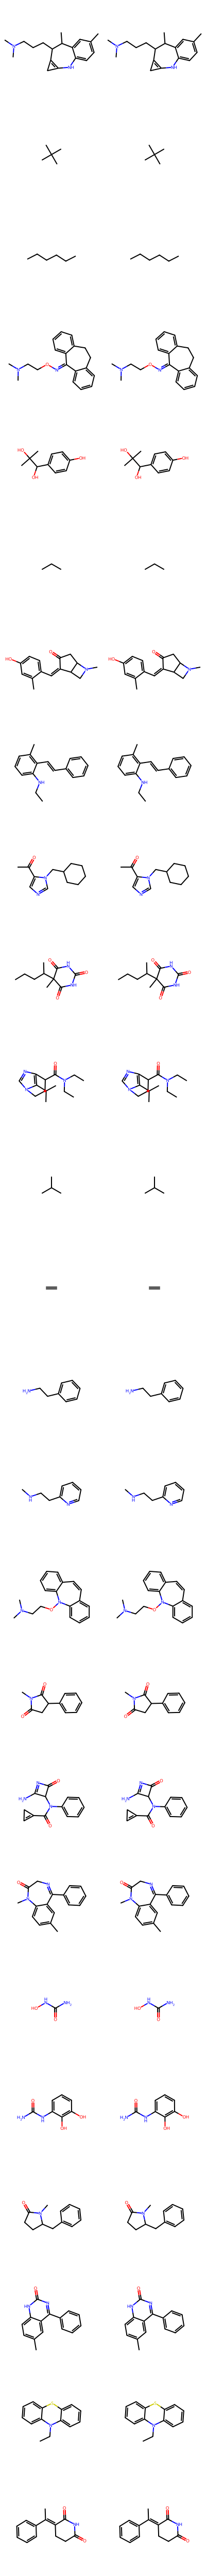

In [ ]:

Draw.MolsToGridImage(showmols, molsPerRow=2)

In [ ]:
with open('bbbp_gen_fsr.txt', 'w') as f:
    for line in finetuned_smiles:
        f.write(f"{line}\n")

In [ ]:
len(finetuned_smiles)

100